<a href="https://colab.research.google.com/github/hernanmorales-navarrete/EPIC_4/blob/main/Day_2/Intro_DeepLearning_BioimageAnalysis/code/1_NoiseRemoval_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Noise Removal using Autoencoders


- This is a tutorial on the basic noise removal in bioimage analysis (i.e. fluorescence microscopy data) using AutoEncoders

## 1. Importing Modules & Packages

In [19]:
# Libraries for handling URL and file operations
import urllib                     # Library for handling URL operations
import os                         # Library for interacting with the operating system
import zipfile                    # Library for handling zip file operations

# Libraries for numerical and scientific computation
import numpy as np                # NumPy: manipulation of numerical arrays
import scipy.ndimage as ndi       # The image processing package scipy.ndimage
from scipy.ndimage import gaussian_filter  # Gaussian filter function from scipy.ndimage
from math import log10            # Math library for logarithmic calculations
import random                     # Library for random number generation

# Libraries for data visualization and plotting
import matplotlib.pyplot as plt   # The plotting module matplotlib.pyplot as plt
import seaborn as sns             # Seaborn: data visualization library
import pandas as pd               # Pandas: data manipulation and analysis library
import time                       # Time library for measuring execution time

# Libraries for image processing and handling
from PIL import Image             # Pillow: image processing library
from skimage import io            # Scikit-image: image I/O
from skimage.metrics import structural_similarity as ssim  # SSIM: structural similarity index for image quality assessment
from skimage.metrics import peak_signal_noise_ratio as psnr  # PSNR: peak signal-to-noise ratio for image quality assessment
from sklearn.metrics import mean_squared_error as mse  # MSE: mean squared error for image quality assessment
from sklearn.metrics import mean_absolute_error as mae  # MAE: mean absolute error for image quality assessment


# Libraries for machine learning and neural networks
import torch                      # PyTorch: deep learning library
import torch.nn as nn             # PyTorch neural network module
import torch.optim as optim       # PyTorch optimization module
from torch.utils.data import DataLoader, Dataset, random_split  # DataLoader and Dataset modules from PyTorch
from torchvision import transforms  # Transforms module from torchvision for image transformations
from torchsummary import summary    # Summary module from torchsummary for model summary

In [2]:
# Set matplotlib backend
%matplotlib inline
#%matplotlib inline              # Displays as static figure in code cell output
#%matplotlib notebook            # Displays as interactive figure in code cell output
#%matplotlib qt                  # Displays as interactive figure in a separate window

In [3]:
# Check GPU
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
# Allocate memory on the GPU dynamically
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'    # Allow GPU memory to grow as needed

True
Tesla T4


In [4]:
# Set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# DataLoader setup
def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)


# Set seeds for reproducibility
set_seed(20)


## 2. Importing and save data

In [5]:
import urllib
import os
import zipfile

# create a folder for our data.
if not os.path.isdir('./data'):
    os.mkdir('./data')

# check if data has been downloaded already
zipPath="data/snr_7_binning_2.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('http://csbdeep.bioimagecomputing.com/example_data/snr_7_binning_2.zip', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

print("High and low SNR images downloaded from https://csbdeep.bioimagecomputing.com/")

High and low SNR images downloaded from https://csbdeep.bioimagecomputing.com/


In [6]:
# Alternative save data in drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Ploting image example from tre training set

In [7]:
# Function to rescale intensities
def rescale_intensity(image, Imin, Imax):
    """
    Rescale the intensity of an image from the range (Imin0, Imax0) to (Imin, Imax).

    Parameters:
    - image: numpy array, input image with intensity values in the range (Imin0, Imax0)
    - Imin: int or float, minimum intensity value in the output image
    - Imax: int or float, maximum intensity value in the output image

    Returns:
    - numpy array, image with intensity values rescaled to the range (0, 255)
    """
    # get min and max values
    Imin0 = np.amin(image)
    Imax0 = np.amax(image)

    # Save the original data type of the image
    original_dtype = image.dtype

    # Convert image to float for operations
    image = image.astype(float)

    # Rescale the intensities
    rescaled_image = ((image - Imin0) / (Imax0 - Imin0))  # Nomrlaizes to (0,1)
    rescaled_image = (rescaled_image * (Imax - Imin)) + Imin  # Scales to (Imin, Imax)

    # Clip the values to ensure they are within [0, 255]
    rescaled_image = np.clip(rescaled_image, Imin, Imax)

    # Convert back to the original data type
    rescaled_image = rescaled_image.astype(original_dtype)

    return rescaled_image

In [8]:
# Function to plot pairs of images

def pltPair(img1, img2, title1, title2, cmap1, cmap2, lim, fig_size):
    """This function displays a pair of input image with interpolation='none',in the range of lims. """

    plt.figure(figsize=(fig_size,fig_size))
    plt.subplot(1,2,1)
    plt.imshow(img1, interpolation='none', cmap=cmap1, vmin=lim[0], vmax=lim[1])
    plt.title(title1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(1,2,2)
    plt.imshow(img2, interpolation='none', cmap=cmap2, vmin=lim[2], vmax=lim[3])
    plt.title(title2)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()




In [9]:
# Create string variables for the path of the file to load (r before your string creates a 'raw string')

filename_lowSNR  = r'/content/data/train/low/img_0000.tif'
filename_highSNR = r'/content/data/train/GT/img_0000.tif'


In [10]:
# Load the images

# Import the function 'imread' from the module 'skimage.io'.
from skimage.io import imread

img_lowSNR  = imread(filename_lowSNR)
img_highSNR = imread(filename_highSNR)

print('Variable Type: ', type(img_lowSNR))
print('Image data type: ', img_lowSNR.dtype)
print('Image dimension: ', img_lowSNR.shape)
print('Max Intensity low SNR: ', np.amin(img_lowSNR))
print('Min Intensity low SNR: ', np.amax(img_lowSNR))
print('Max Intensity high SNR: ', np.amin(img_highSNR))
print('Min Intensity high SNR: ', np.amax(img_highSNR))


Variable Type:  <class 'numpy.ndarray'>
Image data type:  uint16
Image dimension:  (256, 256)
Max Intensity low SNR:  0
Min Intensity low SNR:  71
Max Intensity high SNR:  119
Min Intensity high SNR:  1307


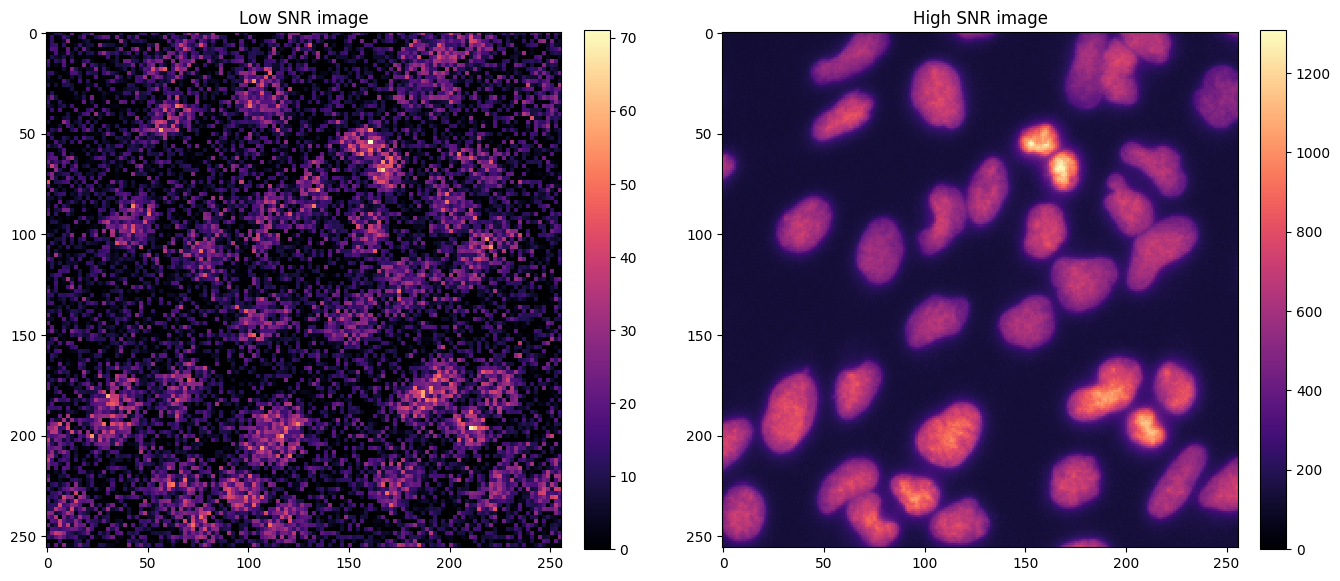

In [11]:
# Plot images

pltPair(img_lowSNR, img_highSNR, 'Low SNR image', 'High SNR image', 'magma', 'magma', [0,71,0,1307], 16)

Max Intensity low SNR:  0
Min Intensity low SNR:  255
Max Intensity high SNR:  0
Min Intensity high SNR:  255


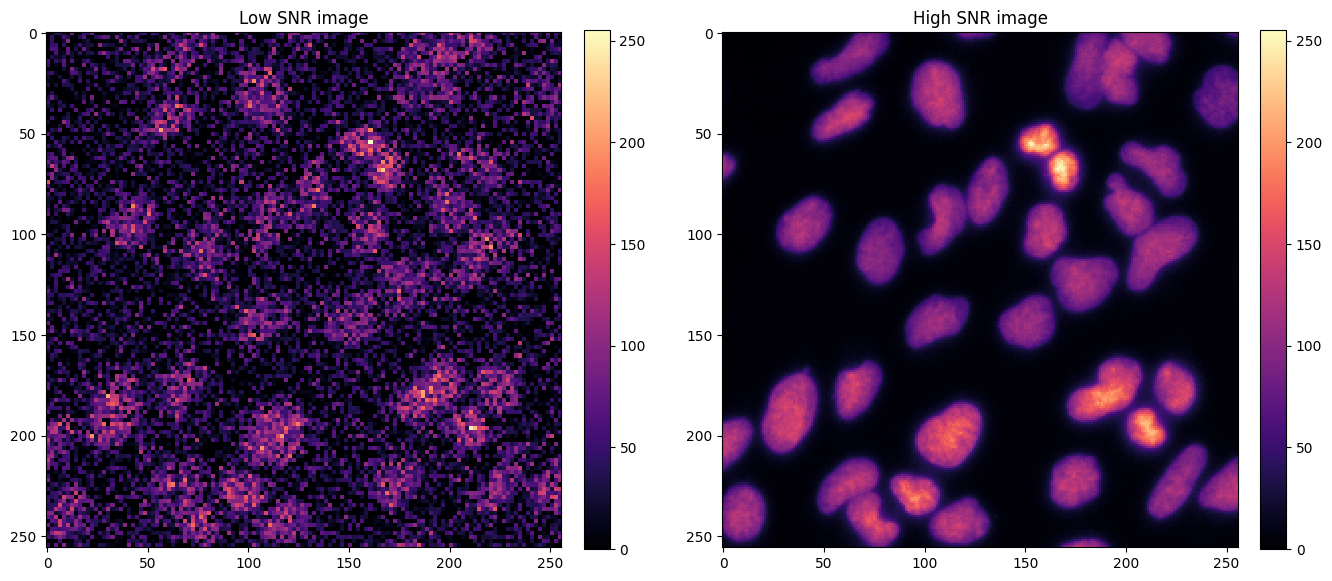

In [12]:
img_lowSNR = rescale_intensity(img_lowSNR, 0, 255)
img_highSNR = rescale_intensity(img_highSNR, 0, 255)

print('Max Intensity low SNR: ', np.amin(img_lowSNR))
print('Min Intensity low SNR: ', np.amax(img_lowSNR))
print('Max Intensity high SNR: ', np.amin(img_highSNR))
print('Min Intensity high SNR: ', np.amax(img_highSNR))


pltPair(img_lowSNR, img_highSNR, 'Low SNR image', 'High SNR image', 'magma', 'magma', [0,255,0,255], 16)

## 4. Image Denoising using classic image processing methods


### Image Filtering

- Removing noise and preserving the structures of interest.

- Genereal noised reduction (smoothing) using a `Gaussian filter`

- Gaussian Smoothing : Gaussian kernel is determined by the standard deviation ($\sigma$) of the Gaussian distribution
- $\sigma$ : large enough to blur out noise but small enough to keep structures of interest

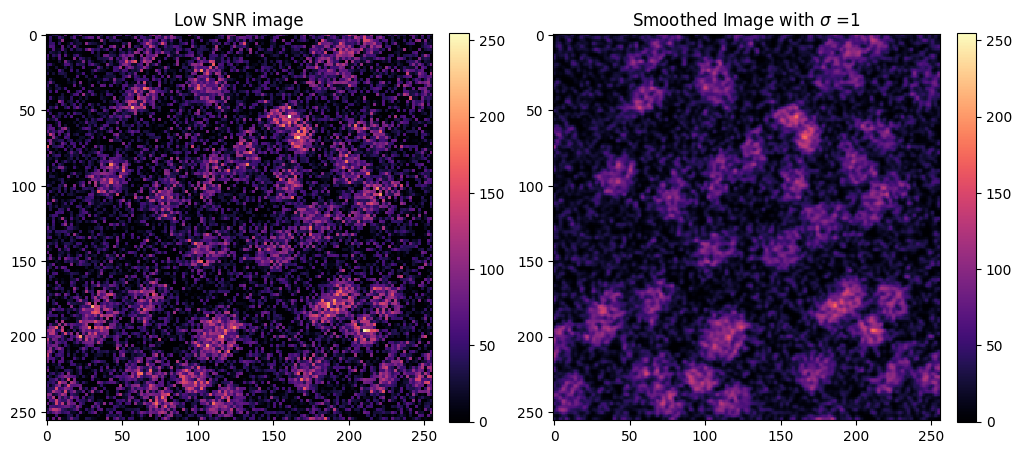

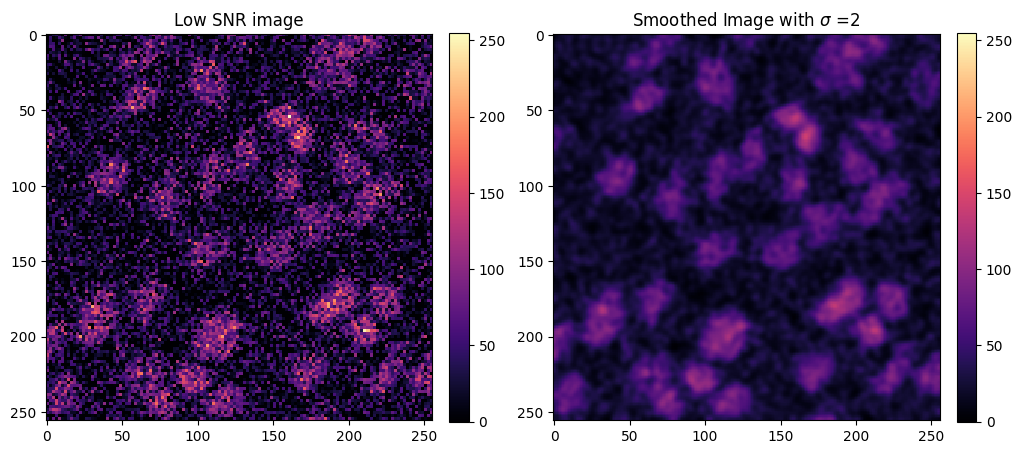

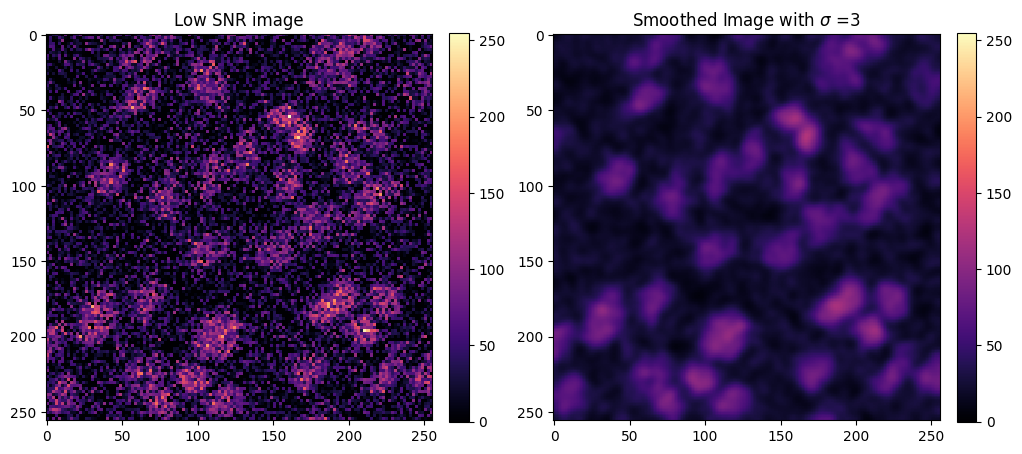

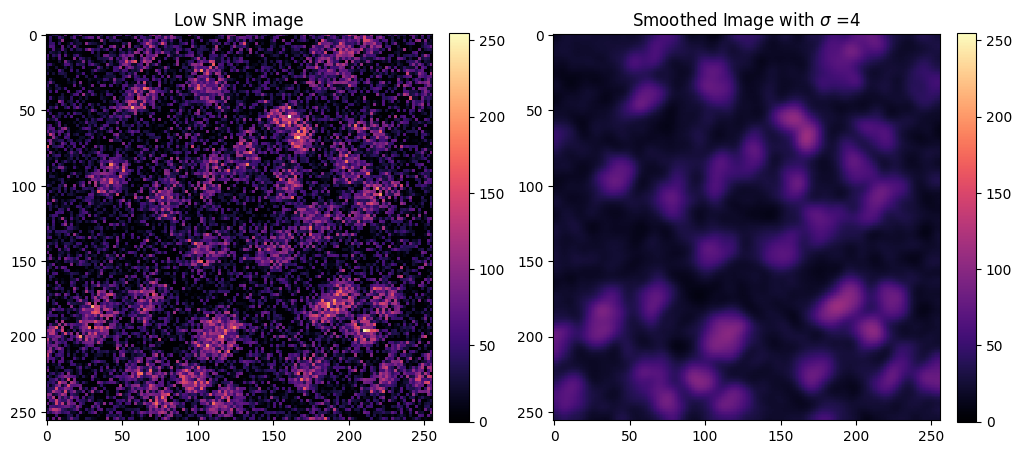

In [13]:
# Test for several values for the smoothing factor sigma
# note: range(start_value, end_value, step)
# Use the Gaussian filter function 'ndi.filters.gaussian_filter' from the 'scipy.ndimage'

for sigma in range(1, 5, 1):
    img_smooth_test = gaussian_filter(img_lowSNR, sigma)
    txt = "$\sigma$ =" + str(sigma)
    pltPair(img_lowSNR, img_smooth_test, 'Low SNR image', 'Smoothed Image with '+"$\sigma$ =" + str(sigma), 'magma', 'magma', [0,255,0,255], 12)


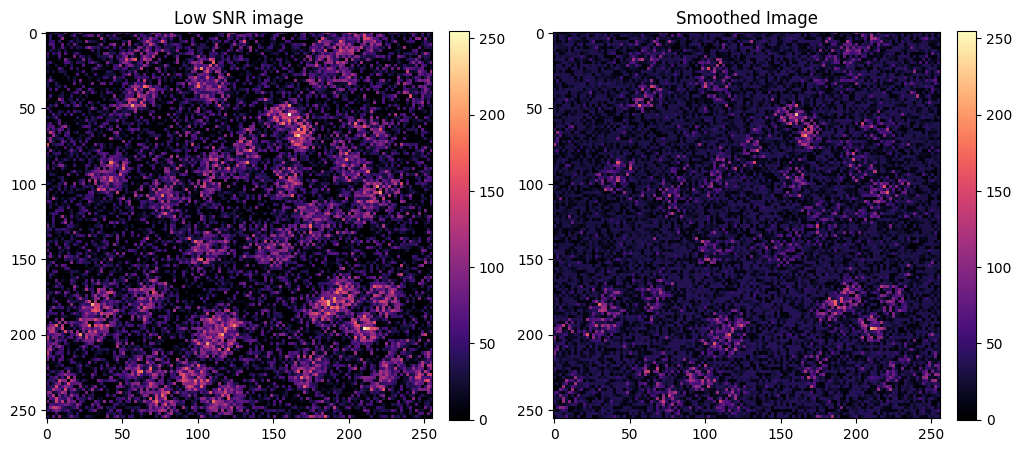

In [14]:
# Perform FFT
f = np.fft.fft2(img_lowSNR)
fshift = np.fft.fftshift(f)

# Create a mask with a central square of 1s
rows, cols = img_lowSNR.shape
crow, ccol = rows//2 , cols//2
mask = np.ones((rows, cols), np.uint8)
r = 1  # Radius of the central square
mask[crow-r:crow+r, ccol-r:ccol+r] = 0

# Apply mask and inverse FFT
fshift = fshift * mask
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

pltPair(img_lowSNR, img_back, 'Low SNR image', 'Smoothed Image', 'magma', 'magma', [0,255,0,255], 12)



## 4. Image Denoising using autoencoders


### Load images

In [15]:
# Custom dataset for loading images
batch_size = 128

class NoisyImageDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.transform = transform
        self.noisy_images = os.listdir(noisy_dir)
        self.clean_images = os.listdir(clean_dir)

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        noisy_img_path = os.path.join(self.noisy_dir, self.noisy_images[idx])
        clean_img_path = os.path.join(self.clean_dir, self.clean_images[idx])
        noisy_image = io.imread(noisy_img_path).astype(np.float32)
        clean_image = io.imread(clean_img_path).astype(np.float32)

       # Normalize to [0, 1] using min and max pixel values of each image
        noisy_image = (noisy_image - noisy_image.min()) / (noisy_image.max() - noisy_image.min())
        clean_image = (clean_image - clean_image.min()) / (clean_image.max() - clean_image.min())


        noisy_image /= noisy_image.max()
        clean_image /= clean_image.max()

        if self.transform:
            noisy_image = self.transform(noisy_image)
            clean_image = self.transform(clean_image)

        return noisy_image, clean_image

# Transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load datasets
full_dataset  = NoisyImageDataset(noisy_dir='/content/data/train/low/', clean_dir='/content/data/train/low/', transform=transform)
test_dataset  = NoisyImageDataset(noisy_dir='/content/data/test/low/',  clean_dir='/content/data/test/GT',    transform=transform)


# Split the full dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

# Print the number of elements and batches in each data loader
print(f'Number of elements in train_loader: {len(train_loader.dataset)}')
print(f'Number of batches in train_loader: {len(train_loader)}')

print(f'Number of elements in val_loader: {len(val_loader.dataset)}')
print(f'Number of batches in val_loader: {len(val_loader)}')

print(f'Number of elements in test_loader: {len(test_loader.dataset)}')
print(f'Number of batches in test_loader: {len(test_loader)}')

Number of elements in train_loader: 1965
Number of batches in train_loader: 16
Number of elements in val_loader: 492
Number of batches in val_loader: 4
Number of elements in test_loader: 615
Number of batches in test_loader: 5


## Plot some images as examples

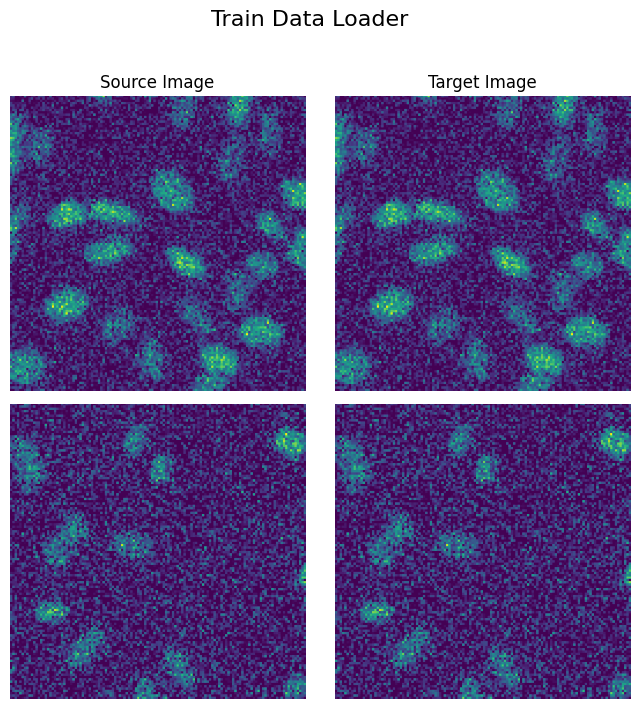

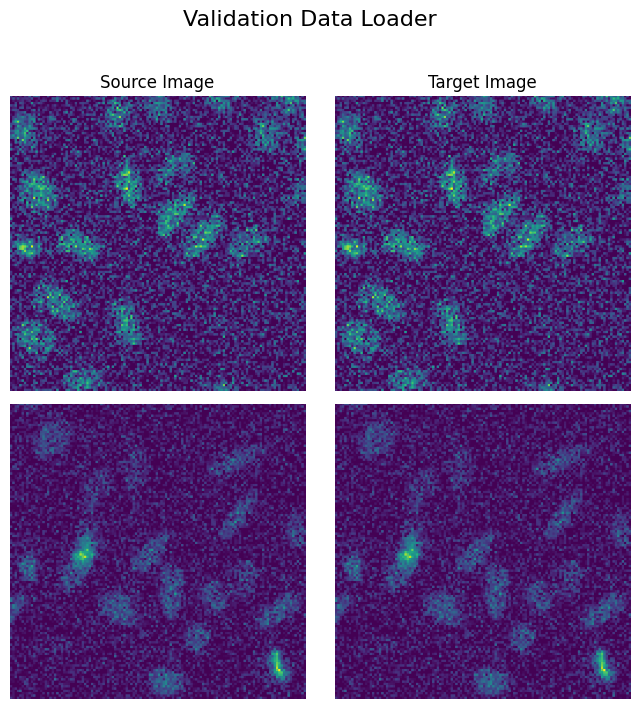

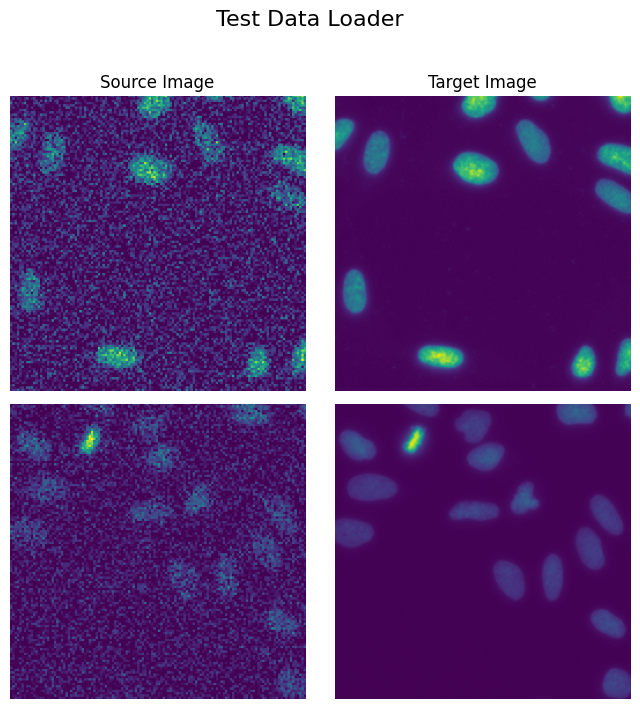

In [16]:
# Function to plot image pairs
def plot_image_pairs(data_loader, title, Nimages):
    data_iter = iter(data_loader)
    fig, axes = plt.subplots(nrows=Nimages, ncols=2, figsize=(8, 4*Nimages))
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(wspace=0.1, hspace=0) # Adjust the spacing between subplots
    noisy_images, clean_images = next(data_iter) # get N pairs of images, N = batchc size

    # Plot fewer image pairs than the batch size
    if Nimages > noisy_images.shape[0]:
        Nimages = noisy_images.shape[0]

    for i in range(Nimages):
      axes[i, 0].imshow(np.squeeze(noisy_images[i]))
      #print(np.amax(noisy_images[i,:,:,:]))
      #print(np.amin(noisy_images[i,:,:,:]))
      axes[i, 0].axis('off')
      axes[i, 1].imshow(np.squeeze(clean_images[i]))
      axes[i, 1].axis('off')
      if i == 0:
          axes[i, 0].set_title('Source Image', fontsize=12)
          axes[i, 1].set_title('Target Image', fontsize=12)
    plt.show()

# Plotting train and test image pairs
plot_image_pairs(train_loader, "Train Data Loader", 2)
plot_image_pairs(val_loader, "Validation Data Loader", 2)
plot_image_pairs(test_loader, "Test Data Loader", 2)

## Define Autoencoder model

In [29]:
class SmallAutoencoder(nn.Module):
    def __init__(self):
        super(SmallAutoencoder, self).__init__()  # Initialize the parent class nn.Module
        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),     # First convolutional layer: 1 input channel, 32 output channels, kernel size 3x3, stride 2, padding 1
            nn.BatchNorm2d(32),                           # Batch normalization to improve training speed and stability
            nn.ReLU(),                                    # ReLU activation function
            nn.Conv2d(32, 64, 3, stride=2, padding=1),    # Second convolutional layer: 32 input channels, 64 output channels, kernel size 3x3, stride 2, padding 1
            nn.BatchNorm2d(64),                           # Batch normalization for 64 channels
            nn.ReLU(),                                    # ReLU activation function
            nn.Conv2d(64, 128, 3, stride=2, padding=1),   # Third convolutional layer: 64 input channels, 128 output channels, kernel size 3x3, stride 2, padding 1
            nn.BatchNorm2d(128),                          # Batch normalization for 128 channels
            nn.ReLU(),                                    # ReLU activation function
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # Fourth convolutional layer: 128 input channels, 256 output channels, kernel size 3x3, stride 2, padding 1
            nn.BatchNorm2d(256),                          # Batch normalization for 256 channels
            nn.ReLU(),                                    # ReLU activation function
        )
        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),   # First transposed convolutional layer: 256 input channels, 128 output channels, kernel size 3x3, stride 2, padding 1, output padding 1
            nn.BatchNorm2d(128),                                           # Batch normalization for 128 channels
            nn.ReLU(),                                                    # ReLU activation function
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),   # Second transposed convolutional layer: 128 input channels, 64 output channels, kernel size 3x3, stride 2, padding 1, output padding 1
            nn.BatchNorm2d(64),                                           # Batch normalization for 64 channels
            nn.ReLU(),                                                    # ReLU activation function
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),    # Third transposed convolutional layer: 64 input channels, 32 output channels, kernel size 3x3, stride 2, padding 1, output padding 1
            nn.BatchNorm2d(32),                                           # Batch normalization for 32 channels
            nn.ReLU(),                                                    # ReLU activation function
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),     # Fourth transposed convolutional layer: 32 input channels, 1 output channel, kernel size 3x3, stride 2, padding 1, output padding 1
            nn.Sigmoid()                                                  # Sigmoid activation function for the final layer to normalize the output between 0 and 1
        )

    def forward(self, x):  # Define the forward pass of the autoencoder
        x = self.encoder(x)  # Pass the input through the encoder
        x = self.decoder(x)  # Pass the encoded input through the decoder
        return x             # Return the reconstructed output

# Initialize model
model = SmallAutoencoder().cuda()
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
       BatchNorm2d-8          [-1, 128, 32, 32]             256
              ReLU-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 16, 16]         295,168
      BatchNorm2d-11          [-1, 256, 16, 16]             512
             ReLU-12          [-1, 256, 16, 16]               0
  ConvTranspose2d-13          [-1, 128, 32, 32]         295,040
      BatchNorm2d-14          [-1, 128,

## Train Model

Epoch [1/100], Train Loss: 0.0813, Val Loss: 0.0364, Time: 10.13 seconds
Epoch [2/100], Train Loss: 0.0322, Val Loss: 0.0198, Time: 10.21 seconds
Epoch [3/100], Train Loss: 0.0195, Val Loss: 0.0158, Time: 10.16 seconds
Epoch [4/100], Train Loss: 0.0147, Val Loss: 0.0141, Time: 9.90 seconds
Epoch [5/100], Train Loss: 0.0129, Val Loss: 0.0134, Time: 10.03 seconds
Epoch [6/100], Train Loss: 0.0119, Val Loss: 0.0121, Time: 10.03 seconds
Epoch [7/100], Train Loss: 0.0114, Val Loss: 0.0115, Time: 9.65 seconds
Epoch [8/100], Train Loss: 0.0110, Val Loss: 0.0114, Time: 10.09 seconds
Epoch [9/100], Train Loss: 0.0108, Val Loss: 0.0108, Time: 10.12 seconds
Epoch [10/100], Train Loss: 0.0105, Val Loss: 0.0105, Time: 10.04 seconds
Epoch [11/100], Train Loss: 0.0104, Val Loss: 0.0104, Time: 9.92 seconds
Epoch [12/100], Train Loss: 0.0102, Val Loss: 0.0104, Time: 10.07 seconds
Epoch [13/100], Train Loss: 0.0102, Val Loss: 0.0102, Time: 10.03 seconds
Epoch [14/100], Train Loss: 0.0100, Val Loss: 0.01

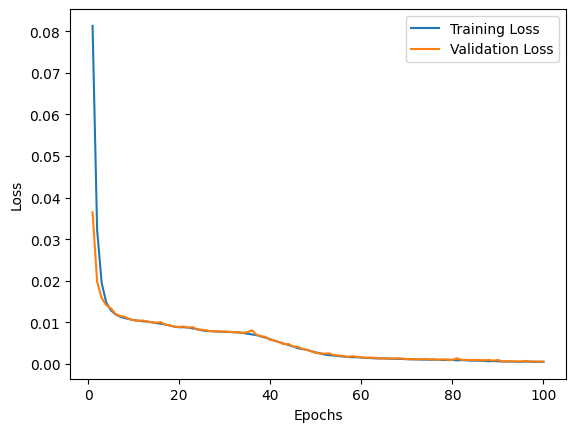

In [30]:
# Training parameters
num_epochs = 100
learning_rate = 0.005
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
patience = 5  # Early stopping patience


# Store losses
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    start_time = time.time()  # Start time for epoch
    model.train()
    train_loss = 0.0
    for data in train_loader:
        noisy_imgs, _ = data
        noisy_imgs = noisy_imgs.cuda()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, noisy_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            noisy_imgs, _ = data
            noisy_imgs = noisy_imgs.cuda()
            outputs = model(noisy_imgs)
            loss = criterion(outputs, noisy_imgs)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    epoch_time = time.time() - start_time  # Calculate epoch duration
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# Plotting the training and validation loss
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Visualize the results

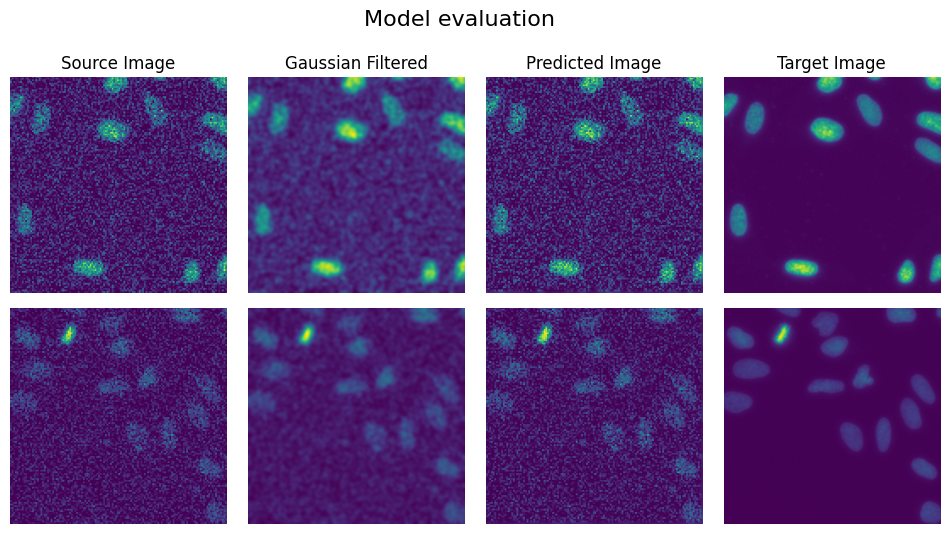

In [31]:
# Model evaluation
NimagesToShow = 2
fig, axes = plt.subplots(nrows=NimagesToShow, ncols=4, figsize=(12, 3*NimagesToShow))
fig.suptitle("Model evaluation", fontsize=16)
fig.subplots_adjust(wspace=0.1, hspace=0) # Adjust the spacing between subplots

model.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    noisy_images, clean_images = next(data_iter)  # get N pairs of images, N = batch size
    noisy_images = noisy_images.cuda()
    outputs = model(noisy_images)

    noisy_images = noisy_images.cpu()  # Move back to CPU
    outputs = outputs.cpu()            # Move outputs to CPU


    # Plot fewer image pairs than the batch size
    if NimagesToShow > noisy_images.shape[0]:
        NimagesToShow = noisy_images.shape[0]

    for i in range(NimagesToShow):
        axes[i, 0].imshow(np.squeeze(noisy_images[i]))
        axes[i, 0].axis('off')
        axes[i, 1].imshow(gaussian_filter(np.squeeze(noisy_images[i]), sigma=2))
        axes[i, 1].axis('off')
        axes[i, 2].imshow(np.squeeze(outputs[i]))
        axes[i, 2].axis('off')
        axes[i, 3].imshow(np.squeeze(clean_images[i]))
        axes[i, 3].axis('off')
        if i == 0:
            axes[i, 0].set_title('Source Image', fontsize=12)
            axes[i, 1].set_title('Gaussian Filtered', fontsize=12)
            axes[i, 2].set_title('Predicted Image', fontsize=12)
            axes[i, 3].set_title('Target Image', fontsize=12)

plt.show()



## Quantify results

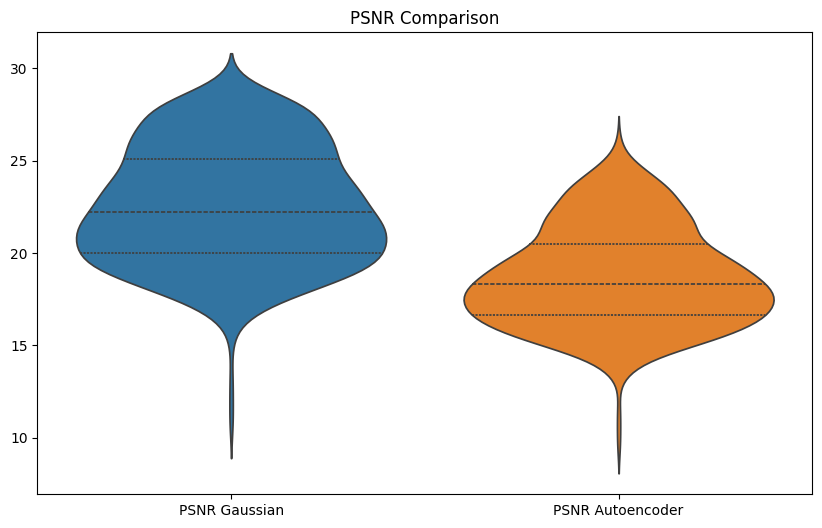

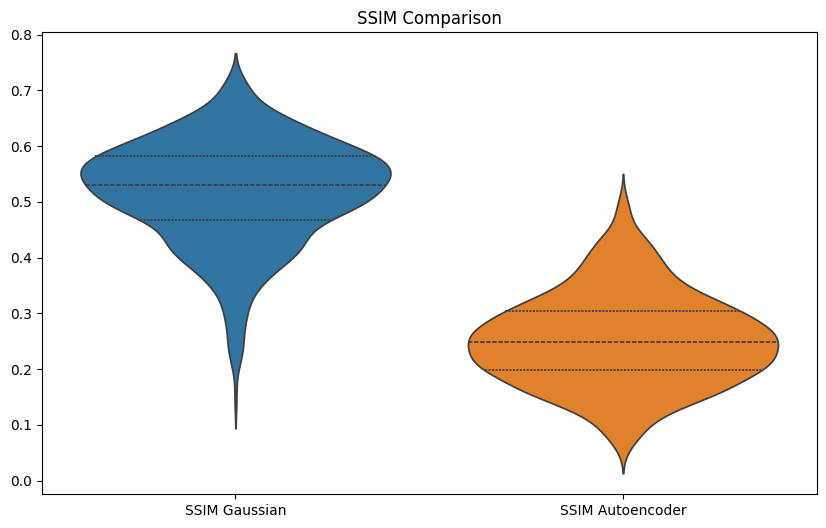

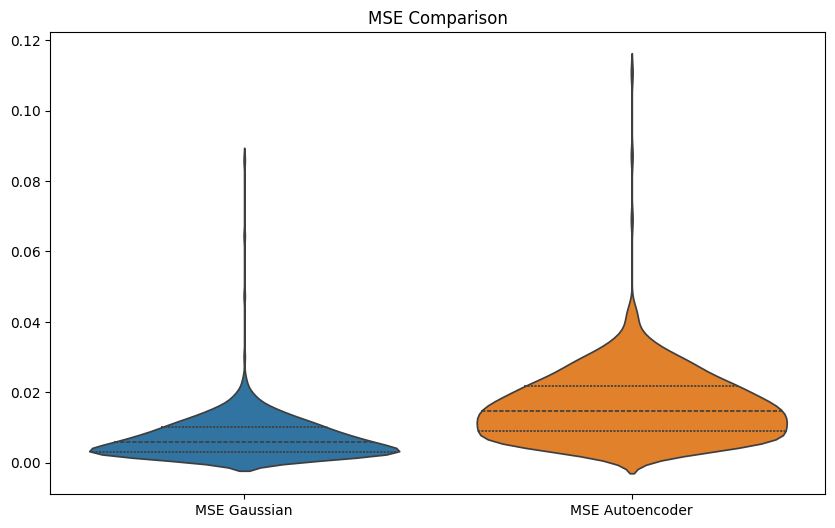

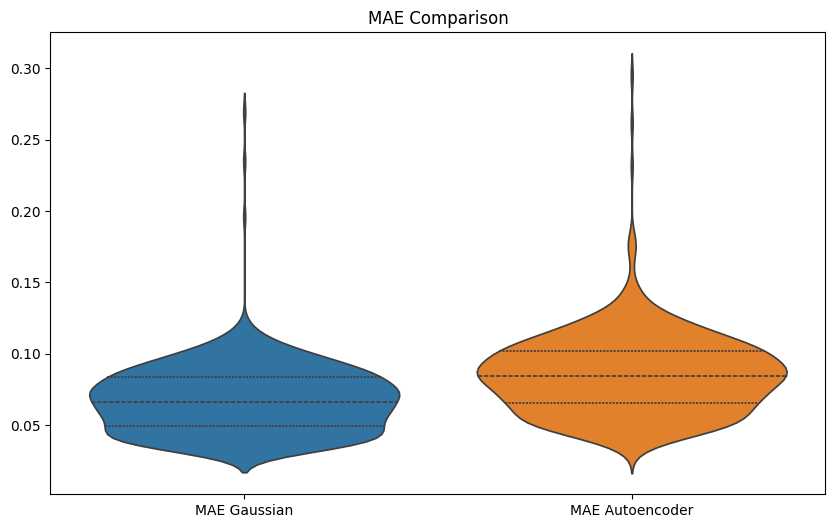

In [32]:
# Metrics
psnr_list, ssim_list, mse_list, mae_list = [], [], [], []
psnr_gaussian, ssim_gaussian, mse_gaussian, mae_gaussian = [], [], [], []

def calculate_metrics(clean, denoised):
    imse = mse(clean, denoised)
    psnr = 10 * log10(1 / imse)
    s = ssim(clean, denoised)
    imae = mae(clean, denoised)
    return psnr, s, imse, imae

with torch.no_grad():
    for i, data in enumerate(test_loader):
        noisy_imgs, clean_imgs = data
        noisy_imgs, clean_imgs = noisy_imgs.cuda(), clean_imgs.cuda()
        outputs = model(noisy_imgs)

        for j in range(len(outputs)):
            noisy_img = noisy_imgs[j].cpu().numpy().squeeze()
            clean = clean_imgs[j].cpu().numpy().squeeze()
            denoised = outputs[j].cpu().numpy().squeeze()
            gaussian_img = gaussian_filter(noisy_img, sigma=2)

            psnr, s, imse, imae = calculate_metrics(clean, denoised)
            psnr_list.append(psnr)
            ssim_list.append(s)
            mse_list.append(imse)
            mae_list.append(imae)

            psnr_g, s_g, imse_g, imae_g = calculate_metrics(clean, gaussian_img)
            psnr_gaussian.append(psnr_g)
            ssim_gaussian.append(s_g)
            mse_gaussian.append(imse_g)
            mae_gaussian.append(imae_g)

# Plotting results
metrics_df = pd.DataFrame({
    'PSNR Autoencoder': psnr_list,
    'PSNR Gaussian': psnr_gaussian,
    'SSIM Autoencoder': ssim_list,
    'SSIM Gaussian': ssim_gaussian,
    'MSE Autoencoder': mse_list,
    'MSE Gaussian': mse_gaussian,
    'MAE Autoencoder': mae_list,
    'MAE Gaussian': mae_gaussian,
})

# Plot PSNR
plt.figure(figsize=(10, 6))
sns.violinplot(data=metrics_df[[ 'PSNR Gaussian','PSNR Autoencoder']], inner="quartile")
plt.title('PSNR Comparison')
plt.show()

# Plot SSIM
plt.figure(figsize=(10, 6))
sns.violinplot(data=metrics_df[['SSIM Gaussian', 'SSIM Autoencoder']], inner="quartile")
plt.title('SSIM Comparison')
plt.show()

# Plot MSE
plt.figure(figsize=(10, 6))
sns.violinplot(data=metrics_df[['MSE Gaussian','MSE Autoencoder']], inner="quartile")
plt.title('MSE Comparison')
plt.show()

# Plot MAE
plt.figure(figsize=(10, 6))
sns.violinplot(data=metrics_df[['MAE Gaussian', 'MAE Autoencoder']], inner="quartile")
plt.title('MAE Comparison')
plt.show()




## To-Do: small project

In [33]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()  # Initialize the parent class nn.Module
        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),     # First convolutional layer: 1 input channel, 32 output channels, kernel size 3x3, stride 2, padding 1
            nn.BatchNorm2d(32),                           # Batch normalization to improve training speed and stability
            nn.ReLU(),                                    # ReLU activation function
            nn.Conv2d(32, 64, 3, stride=2, padding=1),    # Second convolutional layer: 32 input channels, 64 output channels, kernel size 3x3, stride 2, padding 1
            nn.BatchNorm2d(64),                           # Batch normalization for 64 channels
            nn.ReLU(),                                    # ReLU activation function
            nn.Conv2d(64, 128, 3, stride=2, padding=1),   # Third convolutional layer: 64 input channels, 128 output channels, kernel size 3x3, stride 2, padding 1
            nn.BatchNorm2d(128),                          # Batch normalization for 128 channels
            nn.ReLU(),                                    # ReLU activation function
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # Fourth convolutional layer: 128 input channels, 256 output channels, kernel size 3x3, stride 2, padding 1
            nn.BatchNorm2d(256),                          # Batch normalization for 256 channels
            nn.ReLU(),                                    # ReLU activation function
            nn.Conv2d(256, 512, 3)                        # Fifth convolutional layer: 256 input channels, 512 output channels, kernel size 3x3, no stride or padding
        )
        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3),                              # First transposed convolutional layer: 512 input channels, 256 output channels, kernel size 3x3
            nn.BatchNorm2d(256),                                          # Batch normalization for 256 channels
            nn.ReLU(),                                                    # ReLU activation function
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # Second transposed convolutional layer: 256 input channels, 128 output channels, kernel size 3x3, stride 2, padding 1, output padding 1
            nn.BatchNorm2d(128),                                          # Batch normalization for 128 channels
            nn.ReLU(),                                                    # ReLU activation function
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),   # Third transposed convolutional layer: 128 input channels, 64 output channels, kernel size 3x3, stride 2, padding 1, output padding 1
            nn.BatchNorm2d(64),                                           # Batch normalization for 64 channels
            nn.ReLU(),                                                    # ReLU activation function
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),    # Fourth transposed convolutional layer: 64 input channels, 32 output channels, kernel size 3x3, stride 2, padding 1, output padding 1
            nn.BatchNorm2d(32),                                           # Batch normalization for 32 channels
            nn.ReLU(),                                                    # ReLU activation function
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),     # Fifth transposed convolutional layer: 32 input channels, 1 output channel, kernel size 3x3, stride 2, padding 1, output padding 1
            nn.Sigmoid()                                                  # Sigmoid activation function for the final layer to normalize the output between 0 and 1
        )

    def forward(self, x):  # Define the forward pass of the autoencoder
        x = self.encoder(x)  # Pass the input through the encoder
        x = self.decoder(x)  # Pass the encoded input through the decoder
        return x             # Return the reconstructed output